<a href="https://colab.research.google.com/github/soph-colo/data300-time-sequence/blob/main/RNN_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [32]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [33]:
#os.chdir("..")

# Read Data

In [34]:
df = pd.read_excel('01 Call-Center-Dataset.xlsx')
df.head()

,Call Id,Agent,Date,Time,Topic,Answered (Y/N),Resolved,Speed of answer in seconds,AvgTalkDuration,Satisfaction rating
0,ID0001,Diane,2021-01-01,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0
1,ID0002,Becky,2021-01-01,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0
2,ID0003,Stewart,2021-01-01,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0
3,ID0004,Greg,2021-01-01,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0
4,ID0005,Becky,2021-01-01,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0


# Count Calls by Hour

In [35]:
def create_hour(x):
  return x["Time"].hour

df["Hour"] = df.apply(create_hour, axis = 1)

df2 = df.groupby(['Date', 'Hour']).size().to_frame().reset_index()

In [36]:
df2 =df2.rename(columns={"Date": "Date", "Hour": "Hour", 0 : "Count"})

# Data Normalization

In [62]:
mean = df2["Count"].mean()
std = df2["Count"].std()

df2["Normalized"] = (df2["Count"] - mean)/std
df2.head()

,Date,Hour,Count,Normalized
0,2021-01-01,9,4,-0.743672
1,2021-01-01,10,4,-0.743672
2,2021-01-01,11,10,1.082560
3,2021-01-01,12,12,1.691304
4,2021-01-01,13,8,0.473816


In [95]:
column_indices = {name: i for i, name in enumerate(df2.columns)}
#column_indices = column_indices.get("Normalized : 3")
column_indices = {'Normalized' : 3}
print(column_indices)

n = len(df2)
train_df = df2[0:int(n*0.7)]
val_df = df2[int(n*0.7):int(n*0.9)]
test_df = df2[int(n*0.9):]

num_features = df2.shape[1]

{'Normalized': 3}


In [96]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<ipython-input-96-8796fd13a208>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_mean = train_df.mean()
<ipython-input-96-8796fd13a208>:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_std = train_df.std()


# Data Windowing

### 1. Index and Offsets

In [97]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):

    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

w1 = WindowGenerator(input_width=3, label_width=1, shift=1,
                     label_columns=['Normalized'])
w1

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Normalized']

In [98]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [99]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 4, 4)
Inputs shape: (3, 3, 4)
Labels shape: (3, 1, 1)


### 3. Plot

In [100]:
w1.example = example_inputs, example_labels

In [101]:
def plot(self, model=None, plot_col='Normalized', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Hours')

WindowGenerator.plot = plot

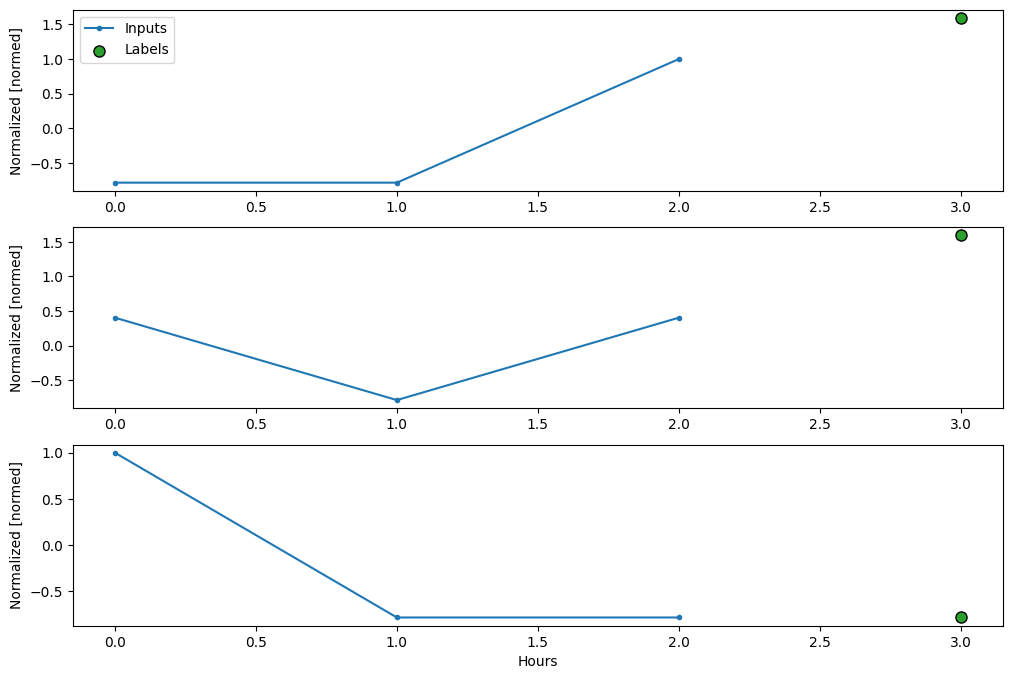

In [102]:
w1.plot()

### 4.

In [103]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [104]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [105]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 3, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [106]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 3, 4)
Labels shape (batch, time, features): (32, 1, 1)


# Baseline

In [107]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Normalized'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Normalized']

In [108]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 4)
Labels shape (batch, time, features): (32, 1, 1)


In [109]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [111]:
column_indices

{'Normalized': 3}

In [113]:
baseline = Baseline(label_index=column_indices['Normalized'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

5/5 [==============================] - 1s 6ms/step - loss: 1.7732 - mean_absolute_error: 1.0582


In [114]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Normalized'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Normalized']

# Build RNN

In [115]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [116]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


In [118]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [119]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

5/5 [==============================] - 0s 6ms/step - loss: nan - mean_absolute_error: nan


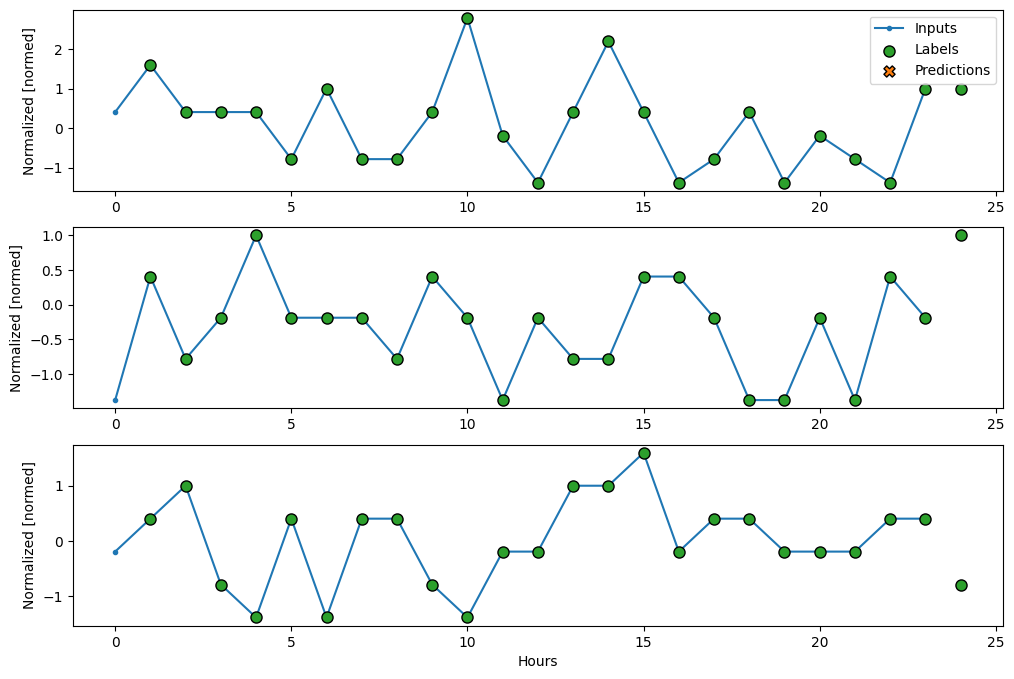

In [120]:
wide_window.plot(lstm_model)

# Peformance

In [122]:
cm = lstm_model.metrics[1]
cm.metrics

[]

In [123]:
val_performance

{'Baseline': {'loss': 1.773242712020874,
  'mean_absolute_error': 1.058194875717163},
 'LSTM': {'loss': nan, 'mean_absolute_error': nan}}

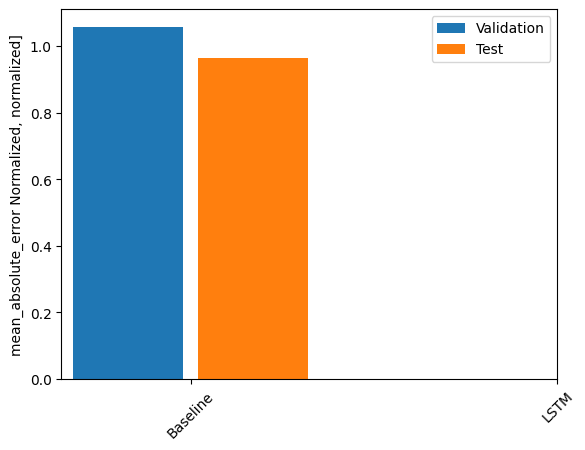

In [126]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error Normalized, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [125]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.9655
LSTM        : nan


# Multi-Step

Total window size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23]
Label column name(s): None

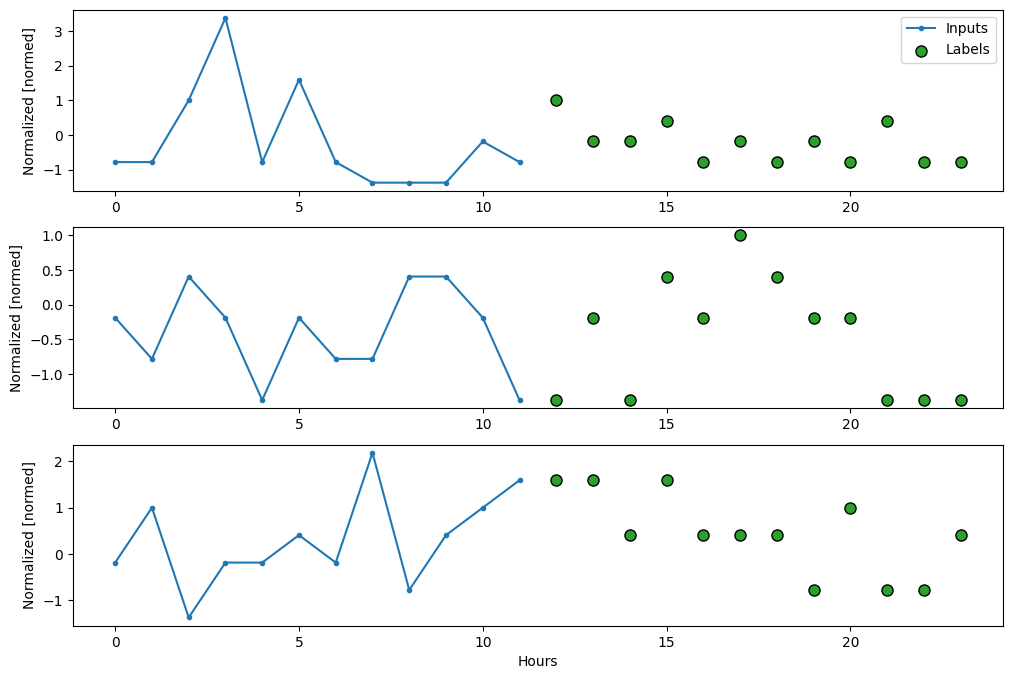

In [135]:
OUT_STEPS = 12
multi_window = WindowGenerator(input_width=12,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

5/5 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


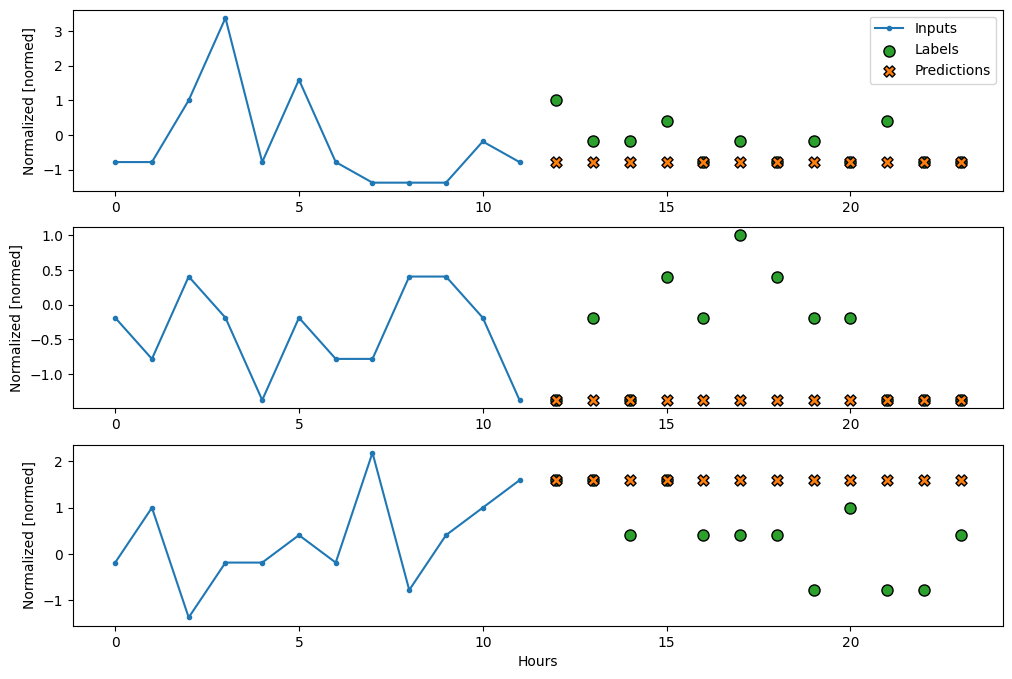

In [137]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

5/5 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


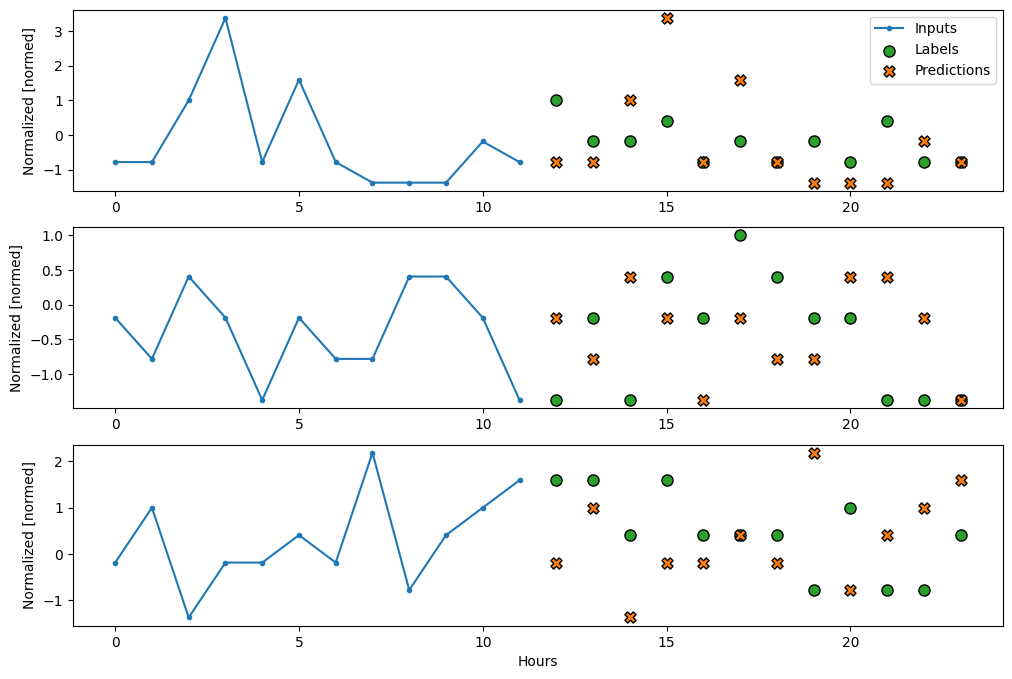

In [138]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

# ours

5/5 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan


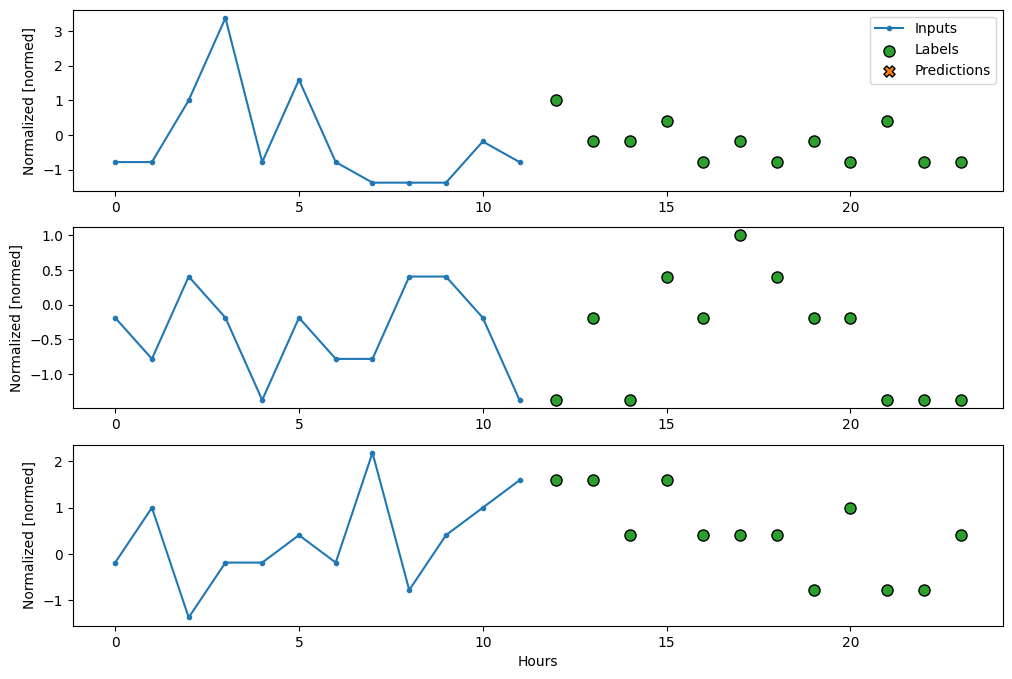

In [140]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

In [141]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [142]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [143]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [144]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 4])

In [145]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [146]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 12, 4)


5/5 [==============================] - 0s 5ms/step - loss: nan - mean_absolute_error: nan


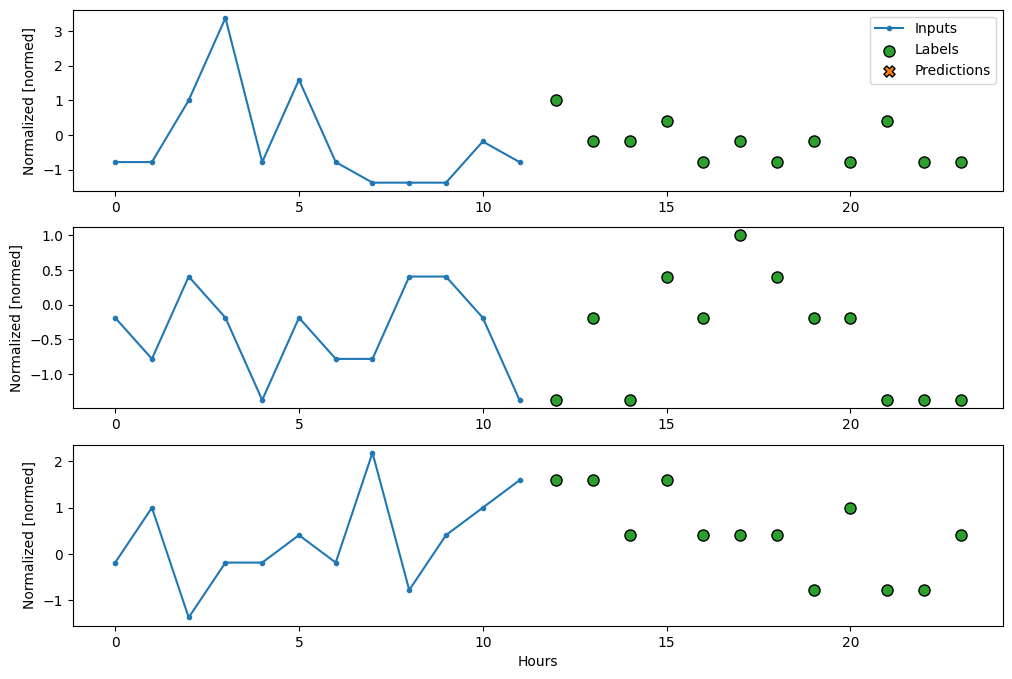

In [147]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

# Performance

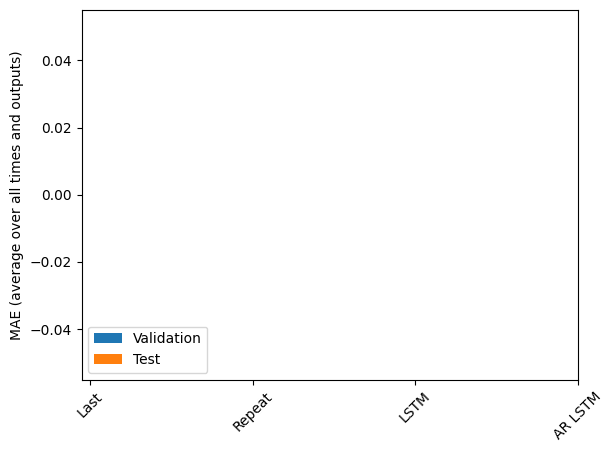

In [150]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [149]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')

Last    : nan
Repeat  : nan
LSTM    : nan
AR LSTM : nan
